In [1]:
import requests
import scipy.io
import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
import numpy as np
import pickle
import string
import re

from __future__ import print_function
import nltk
import os

%matplotlib inline

Import dataframe of games:

In [2]:
pkl_filename_master = "df_games.pkl"
with open(pkl_filename_master, 'rb') as picklefile: 
    df_games = pickle.load(picklefile)
    
    
pkl_filename_master = "stop_words.pkl"
with open(pkl_filename_master, 'rb') as picklefile: 
    stop_words= pickle.load(picklefile)

Define functions that will be used in this notebook:

In [3]:
# Setup nltk corpora path
nltk_path = os.sep.join([os.environ['HOME'], 'nltk_data'])
nltk.data.path.insert(0, nltk_path)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer


from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(str(text)) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(str(token))
    stems = [str(stemmer.stem(t)) for t in filtered_tokens]
    return stems


def get_wordnet_pos(treebank_tag):
    """Convert the part-of-speech naming scheme
       from the nltk default to that which is
       recognized by the WordNet lemmatizer"""

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

    
def preprocess_series_text(data, nltk_path=nltk_path):
    """Perform complete preprocessing on a Pandas series
       including removal of alpha numerical words, normalization,
       punctuation removal, tokenization, stop word removal, 
       and lemmatization."""
    
    # remove alpha numerical words and make lowercase
    alphanum_re = re.compile(r"""\w*\d\w*""")
    alphanum_lambda = lambda x: alphanum_re.sub('', x.strip().lower())

    data = data.map(alphanum_lambda)

    # remove punctuation
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    punc_lambda = lambda x: punc_re.sub(' ', x)

    data = data.map(punc_lambda)

    # tokenize words
    data = data.map(word_tokenize)

    # remove stop words
    sw = stop_words
    #sw = stopwords.words('english')
    sw_lambda = lambda x: list(filter(lambda y: y not in sw, x))

    data = data.map(sw_lambda)

    # part of speech tagging--must convert to format used by lemmatizer
    data = data.map(nltk.pos_tag)
    pos_lambda = lambda x: [(y[0], get_wordnet_pos(y[1])) for y in x]
    data = data.map(pos_lambda)

    # lemmatization
    lemmatizer = WordNetLemmatizer()
    lem_lambda = lambda x: [lemmatizer.lemmatize(*y) for y in x]
    data = data.map(lem_lambda)
    
    
    return data

def bigram_gen(data):
    joined_bigrams = []
    for pair in list(nltk.bigrams(data)):
        joined_bigrams.append(' '.join(pair))
    return data+joined_bigrams

from gensim import corpora
def make_corpus(df, token_column_name, filter_above, filter_below):
    dictionary = corpora.Dictionary(df[token_column_name])
    dictionary.filter_extremes(filter_below, filter_above)
    corpus = [dictionary.doc2bow(text) for text in df[token_column_name]]
    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents: %d' % len(corpus))
    return dictionary, corpus

def get_doc_topic(corpus, model): 
    doc_topic = list() 
    for doc in corpus: 
        doc_topic.append(model.__getitem__(doc, eps=0)) 
    return doc_topic 

def get_topic_to_wordids(model): 
        p = list() 
        for topicid in range(model.num_topics): 
            topic = model.state.get_lambda()[topicid] 
            topic = topic / topic.sum() # normalize to probability dist 
            p.append(topic) 
        return p 


def get_game_in_groups(corpus, model, num_topics, df):
    group_prediction = get_doc_topic(corpus, model)
    keep = [[x[1] for x in document] for document in group_prediction] 
    column_list = ['topic '+ str(num) for num in range(num_topics)]
    df_group = pd.DataFrame([[x[1] for x in document] for document in group_prediction],columns=column_list)
    df_group['max_group'] = df_group.idxmax(axis =1)
    df_group['index1'] = df_group.index
    df['index1'] = df.index
    df_groups_names = pd.merge(df, df_group, on='index1')
    df_groups_predicted = df_groups_names.groupby('max_group')
    df_check = df_groups_predicted.aggregate(lambda x: tuple(x))
    df_check = df_check.reset_index()
    df_check = df_check[['max_group','name','index1']]
    games_categories = df_check['name']
    for groups in games_categories:
        print(groups) 
        print('\n')
        
    return df_groups_predicted, df_check

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

def display_topics_and_titles(matrix, vectorizer, model, no_top_words, title_df_column):
    titles = title_df_column.tolist()
    feature_names = vectorizer.get_feature_names()
    W = model.transform(matrix)
    H = model.components_
    Topic_df = pd.DataFrame()
    
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        topics = ( ", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print(topics)
        topic_features = topics.split(', ')
        Topic_df["Topic %d:" % (topic_idx)] = topic_features
        
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_words]
        #print(top_doc_indices)
        title_list = []
        for doc_index in top_doc_indices:
            title_list.append(titles[doc_index])  
        print(title_list)  
        Topic_df["Games, Topic %d:" % (topic_idx)] = title_list
    
    return Topic_df

no_top_words = 30

In [4]:
test_df = df_games.copy().drop([ u'id', u'year_released', u'geek_rating', u'average_rating', 
       u'nrate', u'pic_url', u'url', u'index1', u'min_players', u'max_players', 
     u'category', u'attributes'], axis =1)

In [5]:
test_df['tokens'] = preprocess_series_text(test_df['description'])

In [6]:
test_df['tokens_w_bigrams'] = test_df.apply(lambda row: bigram_gen(row['tokens']), axis = 1)

In [7]:
test_df.head(1)

,name,description,tokens,tokens_w_bigrams
0,Catan,"In Catan (formerly The Settlers of Catan), pla...","[formerly, settler, dominant, force, island, b...","[formerly, settler, dominant, force, island, b..."


Now prep the text for analysis by making matrices with count vectorizer and tf_idf vectorizer:

In [8]:
def make_corpus(document_tokens_list):
    corpus_orig = []
    for i in document_tokens_list:
        remove_unicode = str(i)
        corpus_orig.append(remove_unicode)
    
    return corpus_orig
        
corpus_orig = make_corpus(list(test_df['tokens']))
corpus_orig_2 = make_corpus(list(test_df['tokens_w_bigrams']))

You can see the additional word combinations in the tokens with bigrams. I'd like to see how much including bigrams will change the topics:

In [9]:
print(corpus_orig[1], len(corpus_orig[1]))
print(corpus_orig_2[1], len(corpus_orig_2[1]))

[u'tile', u'placement', u'draw', u'place', u'tile', u'piece', u'southern', u'french', u'landscape', u'tile', u'might', u'feature', u'city', u'road', u'cloister', u'grassland', u'combination', u'thereof', u'place', u'adjacent', u'tile', u'already', u'play', u'way', u'city', u'connect', u'city', u'road', u'road', u'etcetera', u'place', u'tile', u'decide', u'place', u'meeples', u'area', u'city', u'knight', u'road', u'robber', u'cloister', u'monk', u'grass', u'farmer', u'area', u'complete', u'meeple', u'owner', u'face', u'decision', u'like', u'really', u'worth', u'put', u'last', u'meeple', u'tile', u'expand', u'city', u'place', u'near', u'opponent', u'instead', u'give', u'hard', u'complete', u'project', u'since', u'place', u'tile', u'option', u'place', u'meeple', u'turn', u'proceed', u'quickly', u'even', u'full', u'option', u'possibility'] 847
[u'tile', u'placement', u'draw', u'place', u'tile', u'piece', u'southern', u'french', u'landscape', u'tile', u'might', u'feature', u'city', u'road',

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_df=0.8, min_df=10)

X_cv = cv.fit_transform(corpus_orig)
X_cv = X_cv.toarray()

In [11]:
print(X_cv.shape)
pd.DataFrame(X_cv,
             columns=cv.get_feature_names()).head(1)

(1600, 2110)


,abandon,ability,able,abstract,accept,access,acclaim,accommodate,accomplish,accord,...,year,yellow,yes,yet,yield,york,young,zero,zombie,zone
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
cv2 = CountVectorizer(ngram_range =(1,3),max_df=0.8, min_df=10)

X_cv2 = cv2.fit_transform(corpus_orig).toarray()
print(X_cv2.shape)
pd.DataFrame(X_cv2,
             columns=cv2.get_feature_names()).head(1) #.T

(1600, 2322)


,abandon,ability,able,abstract,abstract strategy,accept,access,acclaim,accommodate,accomplish,...,year war,yellow,yes,yet,yield,york,young,zero,zombie,zone
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.8, min_df=10)

X_tfidf = tfidf.fit_transform(corpus_orig).toarray()

print(X_tfidf.shape)

pd.DataFrame(X_tfidf,
             columns=tfidf.get_feature_names()).head(1) #.T

(1600, 2110)


,abandon,ability,able,abstract,accept,access,acclaim,accommodate,accomplish,accord,...,year,yellow,yes,yet,yield,york,young,zero,zombie,zone
0,0.0,0.038837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
tfidf2 = TfidfVectorizer(max_df=0.8, min_df=10,ngram_range =(1,2))

X_tfidf2 = tfidf2.fit_transform(corpus_orig).toarray()
print(X_tfidf2.shape)
pd.DataFrame(X_tfidf2,
             columns=tfidf2.get_feature_names()).head(1) #.T

(1600, 2322)


,abandon,ability,able,abstract,abstract strategy,accept,access,acclaim,accommodate,accomplish,...,year war,yellow,yes,yet,yield,york,young,zero,zombie,zone
0,0.0,0.037822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Try some topic modeling!

from http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

#### LDA:

In [15]:
from pprint import pprint
from sklearn.decomposition import LatentDirichletAllocation

In [16]:
n_topics = 12
n_iter = 20

lda1 = LatentDirichletAllocation(n_topics=n_topics,
                                max_iter=n_iter,
                                random_state=42)

lda1.fit(X_cv)


/anaconda/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=20,
             mean_change_tol=0.001, n_jobs=1, n_topics=12, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [17]:
n_top_words = 20
tf_feature_names = cv.get_feature_names()
print_top_words(lda1, tf_feature_names, n_top_words)

Topic #0: build, building, resource, world, worker, empire, map, power, city, civilization, great, war, money, action, trade, need, land, system, provide, technology
Topic #1: wing, ghost, street, forest, fighter, pilot, murder, crime, mystery, farm, tie, mr, solve, scientist, medium, war, suspect, detective, case, wine
Topic #2: deck, set, play, like, character, release, add, hand, round, well, box, give, start, go, draw, include, base, feature, change, allow
Topic #3: piece, place, move, animal, color, tower, opponent, block, pawn, region, side, marker, play, square, win, row, wooden, red, make, around
Topic #4: city, resource, dice, ring, bid, roll, build, year, disease, tile, people, settler, bridge, road, settlement, land, earth, hotel, property, improvement
Topic #5: team, guess, word, agent, letter, secret, season, party, clue, question, timer, second, figure, field, hidden, fan, ball, crystal, deduction, close
Topic #6: control, power, action, city, character, influence, battle

In [18]:
no_top_words = 20

LDA_1_df = display_topics_and_titles(X_cv, cv, lda1, no_top_words, test_df['name'])


Topic 0:
build, building, resource, world, worker, empire, map, power, city, civilization, great, war, money, action, trade, need, land, system, provide, technology
[u'The Manhattan Project: Energy Empire', u'Historia', u'Panzer Leader', u'Power Grid: Benelux/Central Europe', u'PanzerBlitz', u'Axis & Allies', u'Axis & Allies: Europe', u'Progress: Evolution of Technology', u'Diplomacy', u'Twilight Struggle', u'Constantinopolis', u'Oh My Goods!', u'Age of Industry', u'Axis & Allies Anniversary Edition', u'Wealth of Nations', u'Spyrium', u'Java', u'Axis & Allies', u'Planet Steam', u'CO\u2082']
Topic 1:
wing, ghost, street, forest, fighter, pilot, murder, crime, mystery, farm, tie, mr, solve, scientist, medium, war, suspect, detective, case, wine
[u'Fluxx', u'Zombie Fluxx', u'Star Wars: X-Wing Miniatures Game \u2013 X-Wing Expansion Pack', u'Star Wars: X-Wing Miniatures Game \u2013 TIE Interceptor Expansion Pack', u'Star Wars: X-Wing Miniatures Game \u2013 TIE Advanced Expansion Pack', u'M

In [19]:
n_topics = 12
n_iter = 20

lda2 = LatentDirichletAllocation(n_topics=n_topics,
                                max_iter=n_iter,
                                random_state=42)

lda2.fit(X_cv2)

/anaconda/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=20,
             mean_change_tol=0.001, n_jobs=1, n_topics=12, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [20]:
n_top_words = 20
tf_feature_names_2 = cv2.get_feature_names()
#print(tf_feature_names_2)
print_top_words(lda2, tf_feature_names_2, n_top_words)

Topic #0: build, action, building, city, resource, money, round, ship, good, gain, order, need, land, buy, earn, best, place, choose, trade, work
Topic #1: empire, ship, star, planet, space, faction, war, alien, mission, galaxy, command, colony, system, fleet, imperial, wing, combat, star war, trade, objective
Topic #2: battle, king, god, army, clan, phase, hill, order, unit, power, throne, strategy, capital, kingdom, avalon, prince, knight, avalon hill, blood, house
Topic #3: tile, dice, move, roll, place, space, token, round, color, start, next, show, chip, track, settlement, another, win, guess, take, reach
Topic #4: deck, hero, monster, set, dungeon, adventure, character, dragon, world, battle, base, treasure, magic, quest, power, spell, fight, defeat, scenario, ability
Topic #5: animal, worker, power, field, tribe, eacute, plant, pyramid, grid, specie, special power, place, bet, need, spot, caravan, special, sheep, available, placement
Topic #6: island, treasure, answer, level, es

In [21]:
no_top_words = 20

LDA_2_df = display_topics_and_titles(X_cv2, cv2, lda2, no_top_words, test_df['name'])

Topic 0:
build, action, building, city, resource, money, round, ship, good, gain, order, need, land, buy, earn, best, place, choose, trade, work
[u'Le Havre: The Inland Port', u'Fresco', u'Industria', u'Capitol', u'Le Havre', u'Homesteaders', u'Saint Petersburg', u'The Gallerist', u'Java', u'Hansa', u'Palazzo', u'Istanbul: Mocha & Baksheesh', u'Cuba', u'Village Inn', u'Toledo', u'Pay Day', u'Luna', u'Bruxelles 1893', u'El Caballero', u'Brew Crafters']
Topic 1:
empire, ship, star, planet, space, faction, war, alien, mission, galaxy, command, colony, system, fleet, imperial, wing, combat, star war, trade, objective
[u'Eclipse', u'Cosmic Encounter', u'Monopoly: Star Wars', u'Among the Stars', u'Star Wars: Rebellion', u'Risk: Star Wars Edition', u'Star Wars: X-Wing Miniatures Game \u2013 A-Wing Expansion Pack', u'Star Realms: Crisis \u2013 Bases & Battleships', u'Star Realms: Crisis \u2013 Events', u'Star Wars: X-Wing Miniatures Game \u2013 TIE Interceptor Expansion Pack', u'Cosmic Encount

#### NMF:

In [22]:
n_samples = X_tfidf.shape[0]
n_features = X_tfidf.shape[1]
#n_features = 1000
n_components = 12   #This is number of topics
n_top_words = 20


from sklearn.decomposition import NMF

nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(X_tfidf)


print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

# Fit the NMF model
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))




Topics in NMF model (Frobenius norm):
Topic #0: building, build, worker, resource, phase, money, construct, action, round, provide, good, civilization, age, architect, trade, acquire, production, develop, castle, place
Topic #1: monster, dungeon, hero, treasure, level, dragon, encounter, defeat, adventure, deck, quest, adventurer, acquire, spell, kill, class, trap, zombie, villain, bos
Topic #2: tile, place, color, adjacent, settlement, road, field, side, meeples, hex, island, score, area, next, type, connect, match, water, worker, landscape
Topic #3: round, action, hand, deck, place, color, play, draw, move, win, value, start, five, money, order, choose, score, high, give, face
Topic #4: war, world, battle, power, army, unit, control, scenario, faction, force, set, empire, map, system, combat, star, base, command, fight, deck
Topic #5: piece, place, move, opponent, square, color, tower, capture, hive, row, make, stack, white, shape, block, jump, set, project, black, abstract
Topic #6

In [23]:
no_top_words = 20

NMF_1_df = display_topics_and_titles(X_tfidf, tfidf, nmf, no_top_words, test_df['name'])


Topic 0:
building, build, worker, resource, phase, money, construct, action, round, provide, good, civilization, age, architect, trade, acquire, production, develop, castle, place
[u'Homesteaders', u'Caylus', u'Ora et Labora', u'The Builders: Middle Ages', u'Harbour', u'Le Havre: The Inland Port', u'Imperial Settlers', u'Keythedral', u'San Juan (second edition)', u'Citadels', u'The City', u'Le Havre', u'Alhambra', u'OddVille', u'Caylus Magna Carta', u'Capitol', u'San Juan', u'Belfort', u'Glass Road', u'New York 1901']
Topic 1:
monster, dungeon, hero, treasure, level, dragon, encounter, defeat, adventure, deck, quest, adventurer, acquire, spell, kill, class, trap, zombie, villain, bos
[u'Thunderstone: Dragonspire', u'Super Munchkin', u'Dungeon!', u'Munchkin', u'Munchkin Cthulhu', u'Munchkin Bites!', u'Super Dungeon Explore', u'Munchkin Fu', u'Dungeons & Dragons: Wrath of Ashardalon Board Game', u'Thunderstone', u'Star Munchkin', u'Dungeons & Dragons: Castle Ravenloft Board Game', u'Munc

In [24]:
nmf2 = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(X_tfidf2)


print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf2.get_feature_names()
print_top_words(nmf2, tfidf_feature_names, n_top_words)



Topics in NMF model (Frobenius norm):
Topic #0: action, building, build, resource, round, money, worker, place, phase, move, order, land, choose, need, good, gain, collect, start, earn, allow
Topic #1: monster, dungeon, hero, treasure, level, dragon, adventure, encounter, defeat, defeat monster, deck, quest, adventurer, acquire, spell, zombie, kill, trap, class, dark
Topic #2: tile, place, color, tile place, place tile, adjacent, score, side, settlement, hex, road, meeples, field, tile tile, match, next, area, another, type, island
Topic #3: deck, hand, round, color, trick, draw, pile, suit, play, discard, face, value, word, win, high, table, trump, row, discard pile, start
Topic #4: war, battle, world, army, unit, scenario, star, faction, force, power, combat, command, deck, set, system, map, control, base, fight, wing
Topic #5: piece, move, place, color, opponent, square, opponent piece, tower, capture, hive, row, place piece, stack, make, block, white, shape, jump, space, set
Topic

In [25]:
NMF_2_df = display_topics_and_titles(X_tfidf2, tfidf2, nmf2, no_top_words, test_df['name'])

Topic 0:
action, building, build, resource, round, money, worker, place, phase, move, order, land, choose, need, good, gain, collect, start, earn, allow
[u'Edo', u'Caylus', u'Homesteaders', u'Ora et Labora', u'The Builders: Middle Ages', u'Bruxelles 1893', u'Le Havre: The Inland Port', u'Saint Petersburg', u'Le Havre', u'Harbour', u'Urban Sprawl', u'Ad Astra', u'Neuland', u'Alhambra', u'Puerto Rico', u'Saint Petersburg (second edition)', u'Imperial Settlers', u'San Juan (second edition)', u'Caylus Magna Carta', u'Tokaido']
Topic 1:
monster, dungeon, hero, treasure, level, dragon, adventure, encounter, defeat, defeat monster, deck, quest, adventurer, acquire, spell, zombie, kill, trap, class, dark
[u'Thunderstone: Dragonspire', u'Super Munchkin', u'Munchkin', u'Munchkin Cthulhu', u'Munchkin Bites!', u'Munchkin Fu', u'Dungeon!', u'Star Munchkin', u'Super Dungeon Explore', u'Thunderstone', u'Dungeons & Dragons: Wrath of Ashardalon Board Game', u'Dungeons & Dragons: Castle Ravenloft Board 

###  Try k means clustering:

http://brandonrose.org/clustering

K means clustering - 11 clusters

In [26]:
from sklearn.cluster import KMeans

num_clusters = 11

km = KMeans(n_clusters=num_clusters)

%time km.fit(X_tfidf2)

clusters = km.labels_.tolist()

CPU times: user 9.93 s, sys: 2.2 s, total: 12.1 s
Wall time: 6.78 s


In [27]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

#joblib.dump(km,  'doc_cluster_8.pkl')

#km = joblib.load('doc_cluster_8.pkl')
#clusters = km.labels_.tolist()

In [28]:
len(clusters)

1600

In [30]:
titles = test_df['name'].tolist()

games = { 'title': titles, 'cluster': clusters}

frame = pd.DataFrame(games, index = [clusters] , columns = ['title','cluster'])

In [31]:
frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

6     464
0     212
3     162
10    148
5     130
4     121
8     100
2      78
9      65
1      65
7      55
Name: cluster, dtype: int64

In [32]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
names = tfidf2.get_feature_names()

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    print([names[j] for j in order_centroids[i, :10]])

    print() #add whitespace
    print() #add whitespace
    
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace


Top terms per cluster:

Cluster 0 words:[u'character', u'deck', u'hero', u'adventure', u'zombie', u'world', u'alien', u'battle', u'scenario', u'horror']


Cluster 0 titles: Pandemic, Arkham Horror, Battlestar Galactica, Dead of Winter: A Crossroads Game, Magic: The Gathering, Coup, Cosmic Encounter, Robinson Crusoe: Adventures on the Cursed Island, Eldritch Horror, Smash Up, Elder Sign, The Lord of the Rings: The Card Game, Descent: Journeys in the Dark (Second Edition), Legendary: A Marvel Deck Building Game, Last Night on Earth: The Zombie Game, Lord of the Rings, Alien Frontiers, Chaos in the Old World, Zombicide, Sentinels of the Multiverse, Mice and Mystics, Mansions of Madness, T.I.M.E Stories, Space Hulk: Death Angel – The Card Game, Pathfinder Adventure Card Game: Rise of the Runelords – Base Set, Talisman (Revised 4th Edition), War of the Ring (first edition), Ascension: Deckbuilding Game, Summoner Wars: Master Set, Tales of the Arabian Nights, BattleLore, HeroQuest, Fury of D

### Ways to assess best number of clusters:

Automatically created module for IPython interactive environment
For n_clusters = 5 The average silhouette_score is : 0.00888318108026


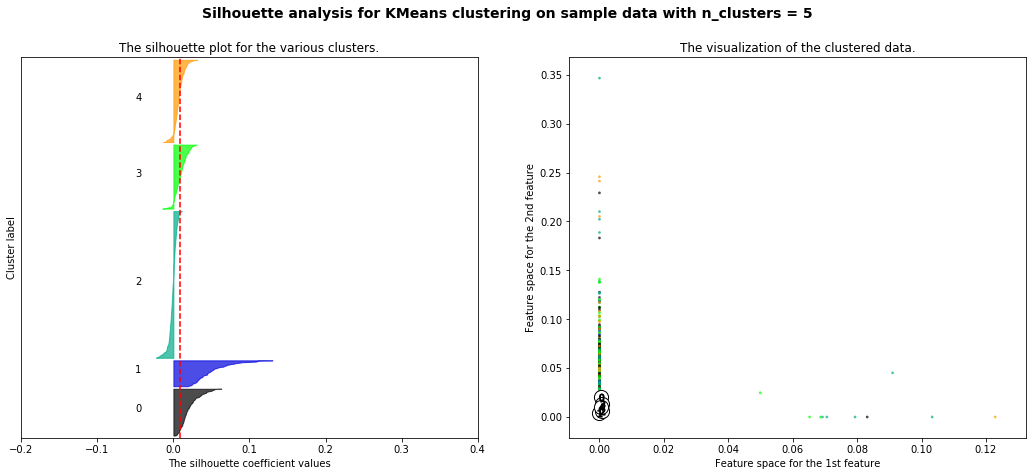

For n_clusters = 6 The average silhouette_score is : 0.0100137232775


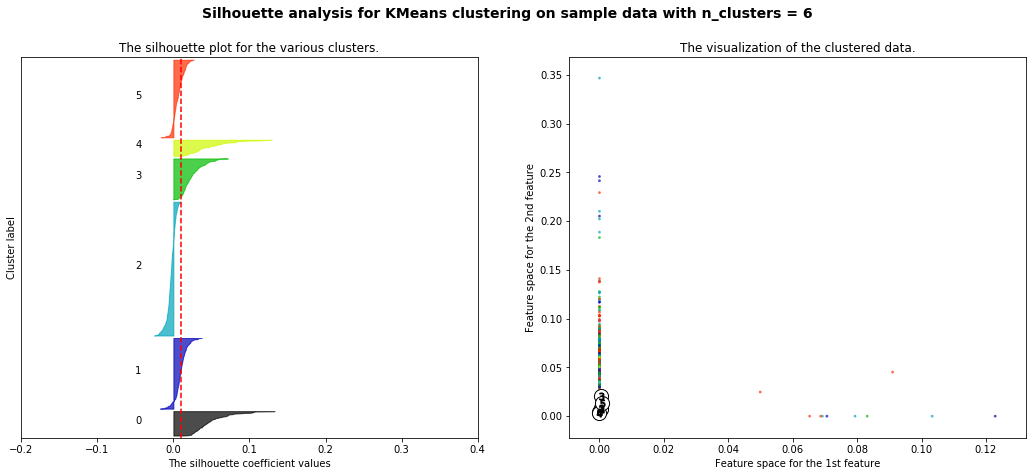

For n_clusters = 7 The average silhouette_score is : 0.0112255578179


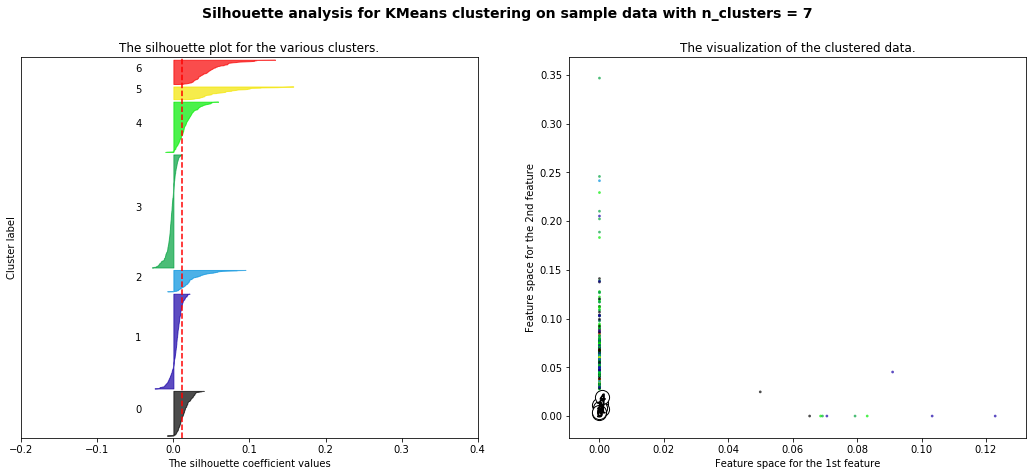

For n_clusters = 8 The average silhouette_score is : 0.0112015139868


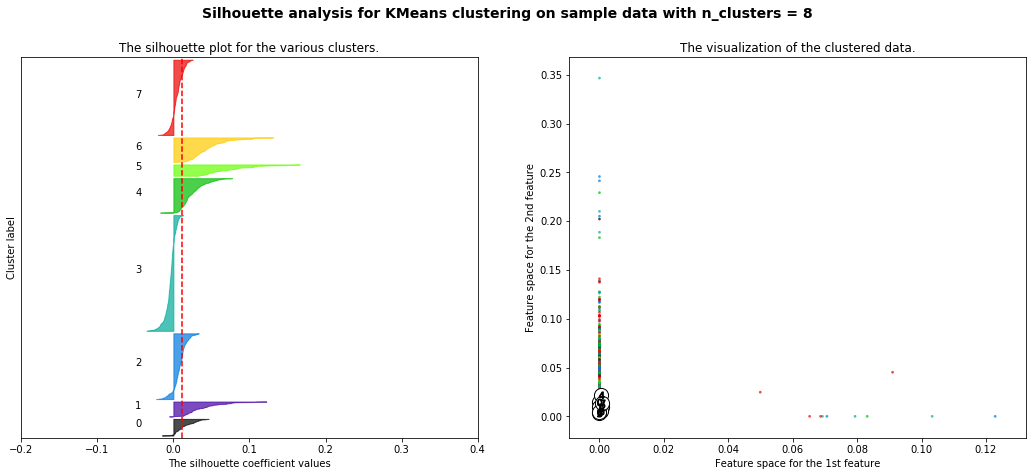

For n_clusters = 9 The average silhouette_score is : 0.0124812115459


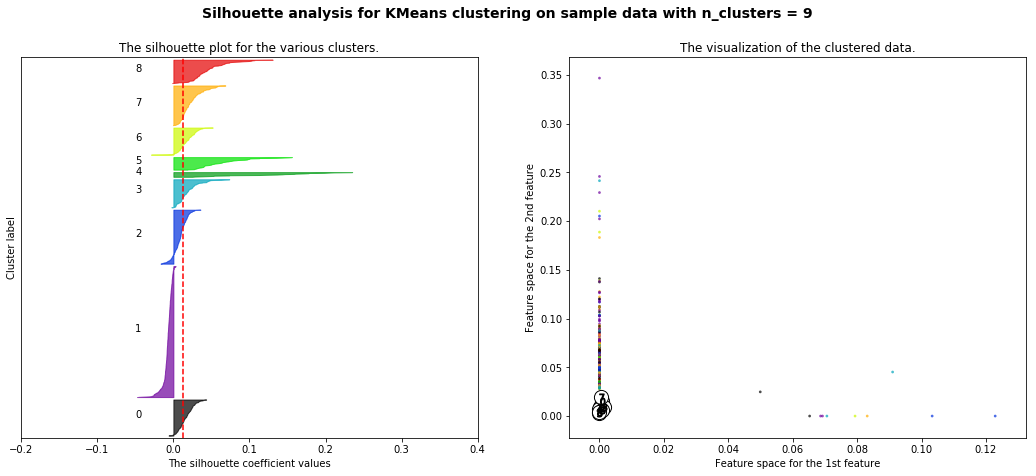

For n_clusters = 10 The average silhouette_score is : 0.0121113566559


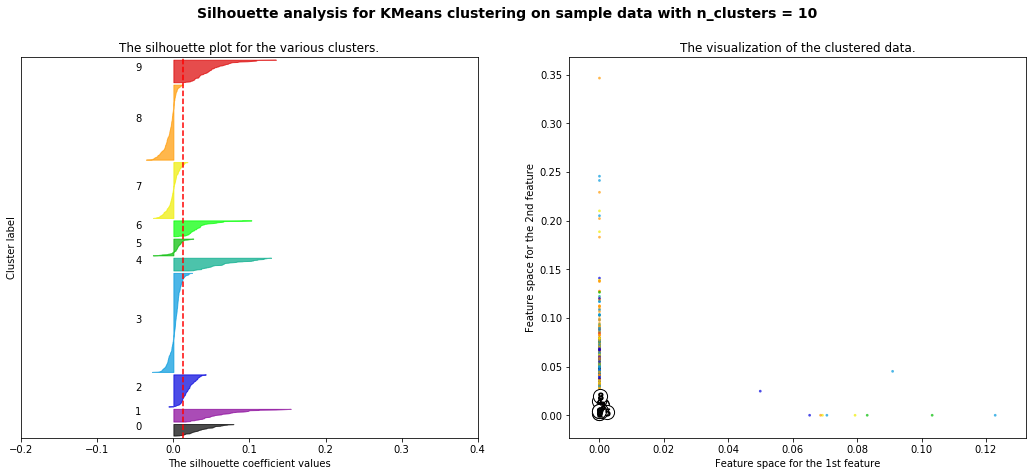

For n_clusters = 11 The average silhouette_score is : 0.0119959566391


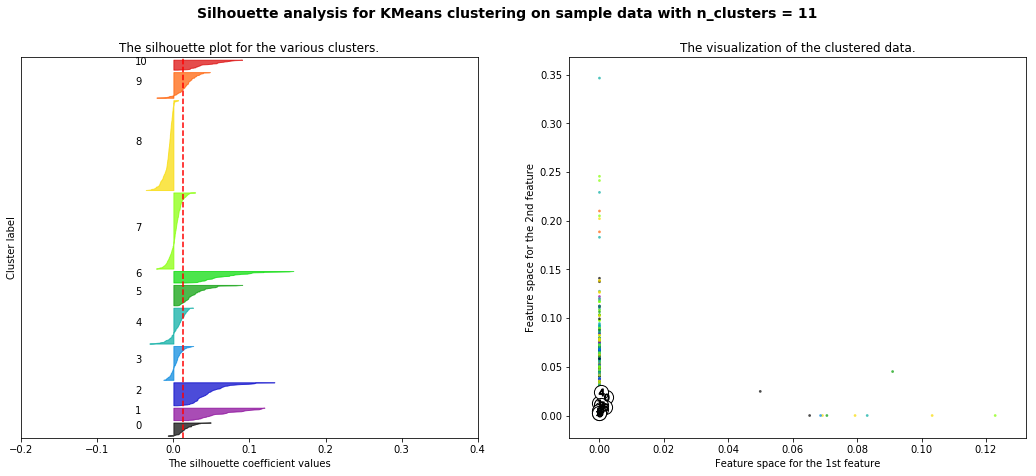

For n_clusters = 12 The average silhouette_score is : 0.012186678671


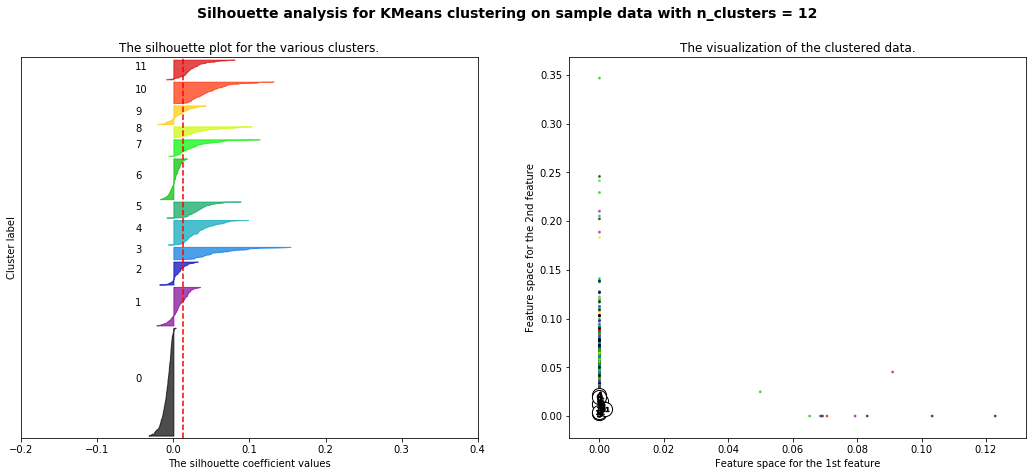

For n_clusters = 13 The average silhouette_score is : 0.014537874999


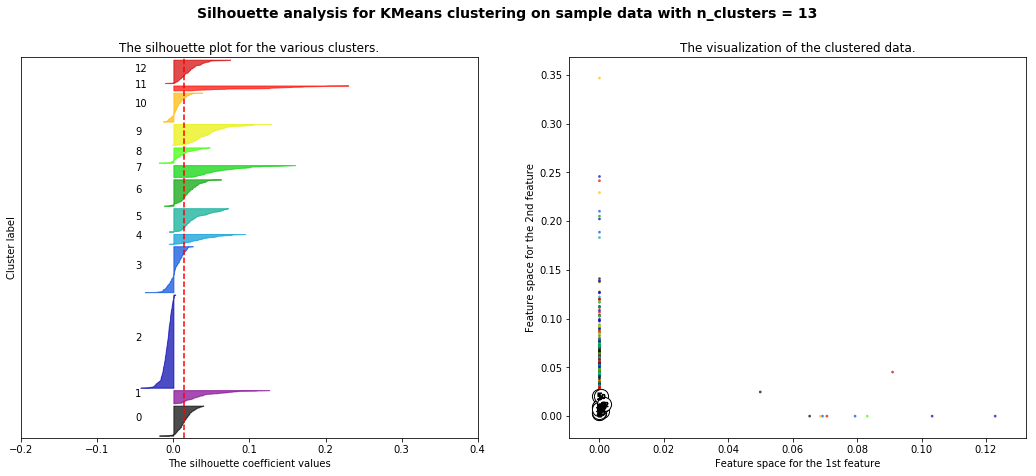

For n_clusters = 14 The average silhouette_score is : 0.0137220669853


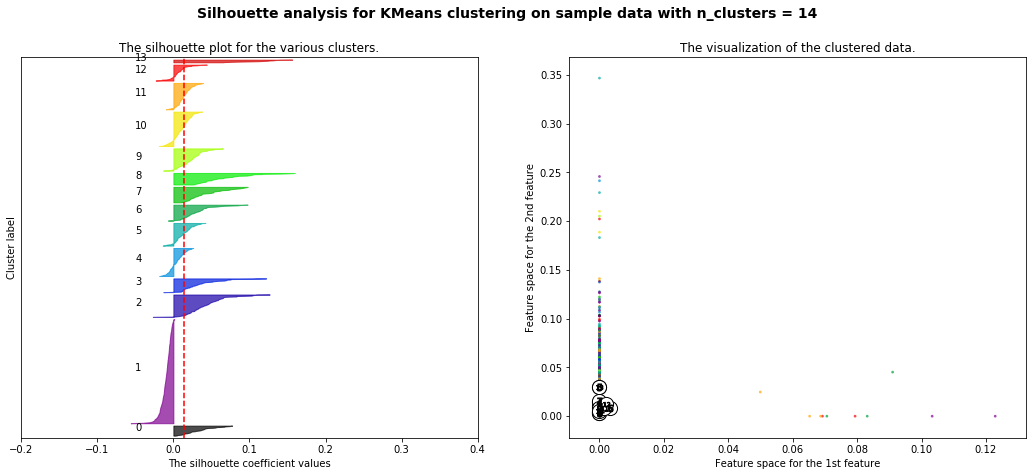

For n_clusters = 15 The average silhouette_score is : 0.0146449769602


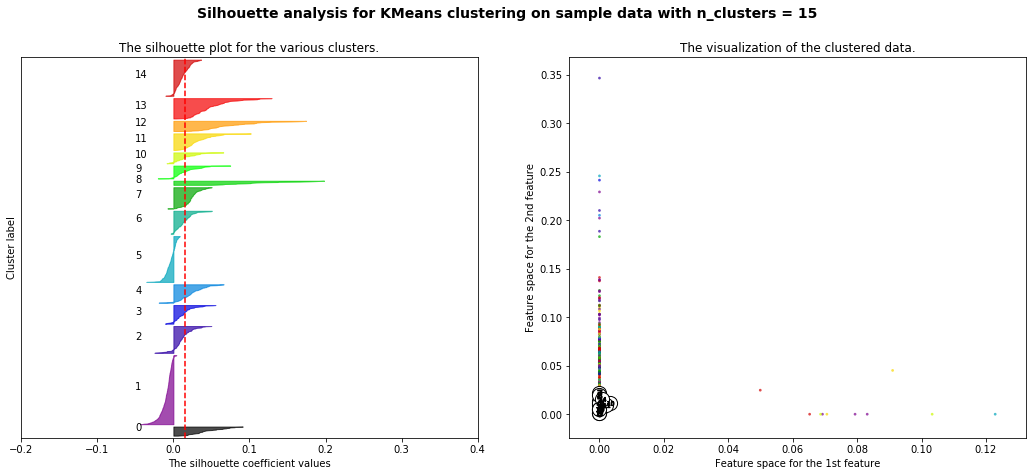

For n_clusters = 16 The average silhouette_score is : 0.0140304523154


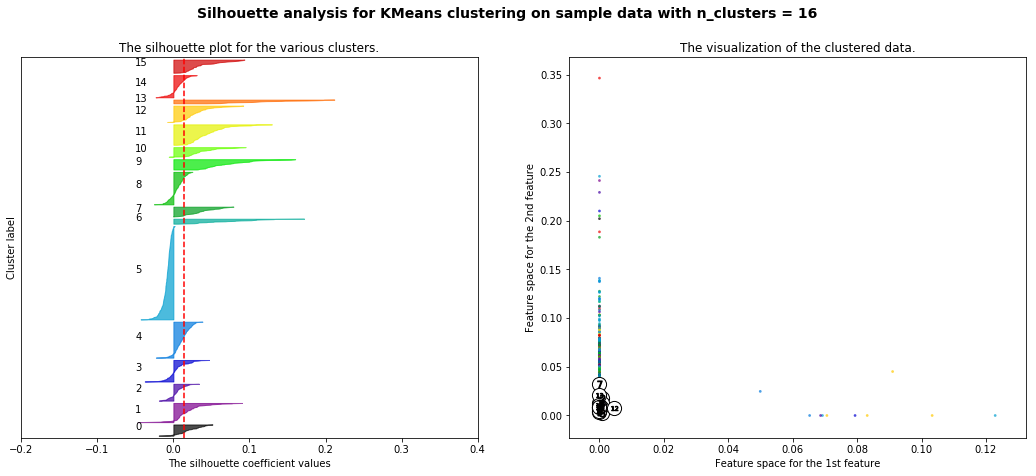

For n_clusters = 17 The average silhouette_score is : 0.0150165910395


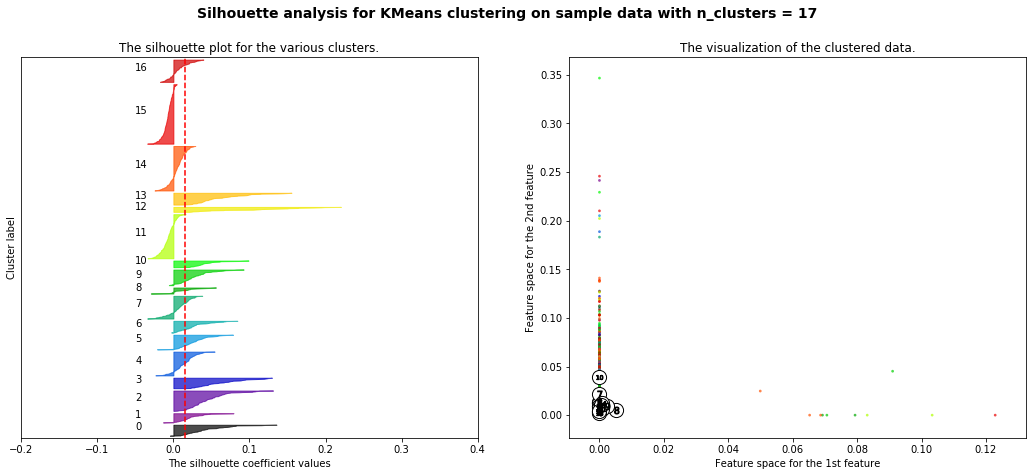

For n_clusters = 18 The average silhouette_score is : 0.0171544117832


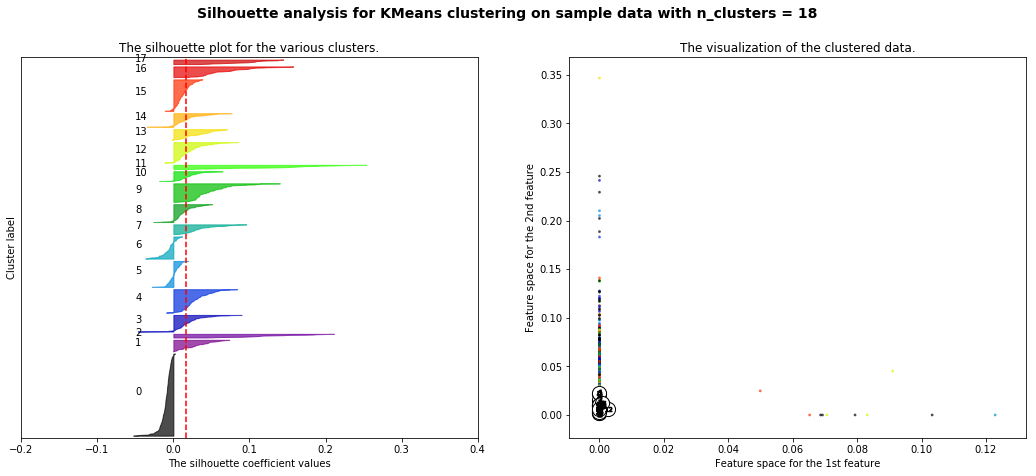

For n_clusters = 19 The average silhouette_score is : 0.0167696873853


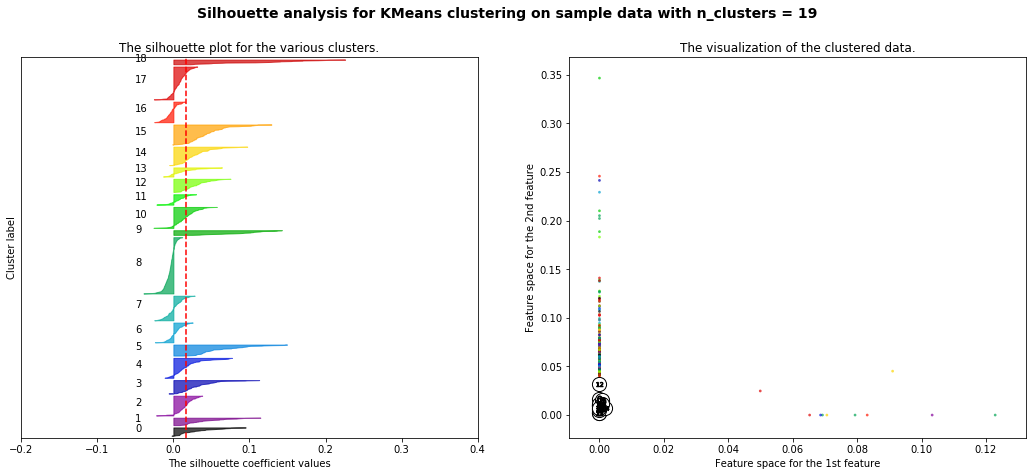

In [48]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
# X, y = make_blobs(n_samples=500,
#                   n_features=2,
#                   centers=4,
#                   cluster_std=1,
#                   center_box=(-10.0, 10.0),
#                   shuffle=True,
#                   random_state=1)  # For reproducibility

range_n_clusters = range(5,20)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 0.4])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_tfidf2) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_tfidf2)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_tfidf2, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_tfidf2, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        #print(ith_cluster_silhouette_values)
        

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, -0.1, 0, 0.1, 0.2,0.3, 0.4])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_tfidf2[:, 0], X_tfidf2[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [42]:
range(5,20)

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

#### kmeans silhouette coefficient and SSE plot to find elbow (does this actually ever work?):

In [33]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale

def get_cluster_centers(X, labels, k_num):
    CC_list = []
    for k in range(k_num):
        # get the mean coordinates of each cluster
        CC_list.append(np.mean(X[labels == k], axis = 0))
    return CC_list

# for each cluster substract the mean from each data point to get the error
# then get the magnitude of each error, square it, and sum it
def get_SSE(X, labels):
    k_num = len(np.unique(labels))
    CC_list = get_cluster_centers(X, labels, k_num)
    CSEs = []
    for k in range(k_num):
        # for each cluster of k we get the coordinates of how far off each point is to the cluster
        error_cords = X[labels == k] - CC_list[k]
        # square the coordinates and sum to get the magnitude squared
        error_cords_sq = error_cords ** 2
        error_mag_sq = np.sum(error_cords_sq, axis = 1)
        # since we already have the magnitude of the error squared we can just take the sum for the cluster
        CSE = np.sum(error_mag_sq)
        CSEs.append(CSE)
    # sum each cluster's sum of squared errors
    return sum(CSEs)

In [34]:
SSEs = []
Sil_coefs = []
Inertia = []
for k in range(2,100):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_tfidf2)
    labels = km.labels_
    Sil_coefs.append(metrics.silhouette_score(X_tfidf2, labels, metric='euclidean'))
    # SSEs.append(get_SSE(X_digits, labels)) # The SSE is just inertia, we
    SSEs.append(km.inertia_)            # could have just said km.inertia_

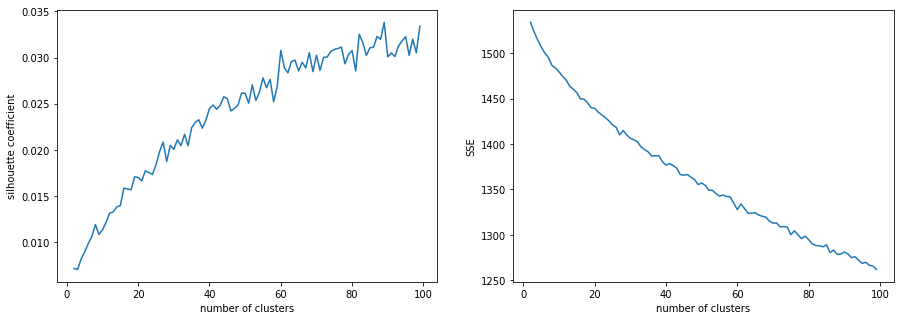

In [36]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,100)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

Try counts rather than the tf-idf:

In [37]:
SSEs = []
Sil_coefs = []
Inertia = []
for k in range(2,100):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_cv2)
    labels = km.labels_
    Sil_coefs.append(metrics.silhouette_score(X_cv2, labels, metric='euclidean'))
    # SSEs.append(get_SSE(X_digits, labels)) # The SSE is just inertia, we
    SSEs.append(km.inertia_)            # could have just said km.inertia_

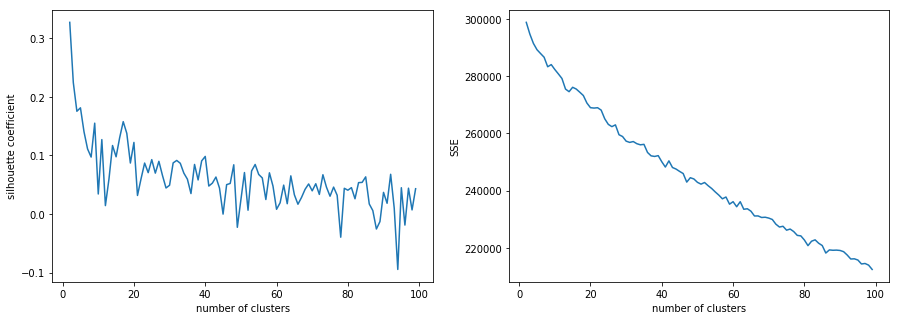

In [38]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,100)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

There is no elbow! Well, it was worth a try :)

Try Lots of Clusters.....

In [110]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print
print

<function print>